# TensorFlow: Tabular Forecasting

*Climate Forecasting Using a 2D Time Series of Multi-Variate Features Over Shifting Windows.*

![delhi](../images/banner/temps.png)

Highly dimensional forecasting is another holy grail of deep learning. This process encodes information about the state of the future as a function of the states of the past. Here the learnable parameters of a neural network effectively serve as coefficients in an 'infinitely' long polynomial equation for predicting the future.

Most tutorials in this space focus on the stock market. To be fair, the NYSE provides a reliable source of uniformly distributed, time-stamped data. However, in this example we'll examine the climate of Delhi in order to predict both it's temperature and humidity in the future.

To do this, we'll use a sliding `aiqc.Window` wherein the past 25 days of data is used to predict the next 5 days of data. We'll study each 25 day interval (e.g. [0...24]) in the dataset and shift it forward by 5 days (e.g. [5...29]) to learn about the transformation it undergoes. 

> It's easy to perform *backcasting* instead of forecasting by switching in `samples_train` as the evaluation data and `samples_evaluate` as the training data when building in `Algorithm.fn_train`!

In [2]:
from aiqc import mlops, datum

---

## Example Data

This dataset is comprised of:

* *Features* = daily weather statistics (temperature, humidity, wind, pressure).

Reference [Example Datasets](example_datasets.ipynb) for more information.

In [4]:
df = datum.to_pandas('delhi_climate.parquet')

In [5]:
df.head()

,day_of_year,temperature,humidity,wind,pressure
0,1,10.000000,84.500000,0.000000,1015.666667
1,2,7.400000,92.000000,2.980000,1017.800000
2,3,7.166667,87.000000,4.633333,1018.666667
3,4,8.666667,71.333333,1.233333,1017.166667
4,5,6.000000,86.833333,3.700000,1016.500000


<AxesSubplot:title={'center':'Temperature'}>

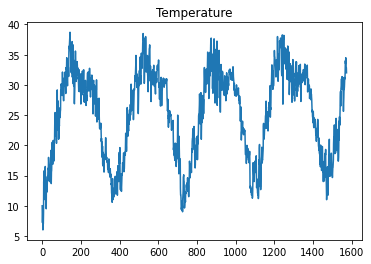

In [6]:
df['temperature'].plot(title='Temperature')

<AxesSubplot:title={'center':'Humidity'}>

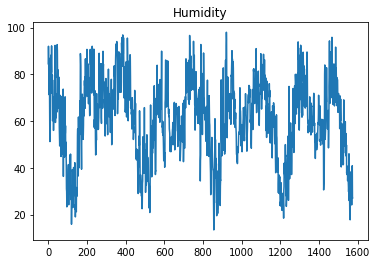

In [7]:
df['humidity'].plot(title='Humidity')

---

## Pipeline

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [9]:
splitset = mlops.Pipeline.Tabular(
    # --- Data source ---
    df_or_path                = df
    , dtype                   = None
    
    # --- Label preprocessing ---
    , label_column            = None
    , label_interpolater      = None
    , label_encoder           = None
    
    # --- Feature preprocessing ---
    , feature_cols_excluded   = ['pressure','wind']
    , feature_interpolaters   = None
    , feature_window          = dict(size_window=25, size_shift=5)
    , feature_encoders        = dict(
        sklearn_preprocess = StandardScaler()
        , dtypes = ['float64', 'int64']
    )
    , feature_reshape_indices = None

    # --- Stratification ---
    , size_test               = 0.12
    , size_validation         = 0.18
    , fold_count              = None
    , bin_count               = None
)


=> Info - System overriding user input to set `sklearn_preprocess.copy=False`.
   This saves memory when concatenating the output of many encoders.


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['temperature', 'humidity', 'day_of_year']

=> Done. All feature column(s) have featurecoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



---

## Modeling

In [7]:
import tensorflow as tf
from tensorflow.keras import layers as l

In [10]:
def fn_build(features_shape, label_shape, **hp):
    m = tf.keras.models.Sequential()
    if hp['LSTM_2']:
        m.add(l.LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=True
        ))
        m.add(l.LSTM(
            hp['neuron_count']
            , activation=hp['activation']
            , return_sequences=False
        ))
    else:
        m.add(l.LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=False
        ))
    # Automatically flattens.
    m.add(l.Dense(label_shape[0]*label_shape[1]*hp['dense_multiplier'], activation=hp['activation']))
    m.add(l.Dropout(0.3))
    m.add(l.Dense(label_shape[0]*label_shape[1], activation=hp['activation'])) ### is this right shape?
    m.add(l.Dropout(0.3))
    # Reshape to be 3D.
    m.add(l.Reshape((label_shape[0], label_shape[1])))
    return model

In [11]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss=loser
        , optimizer=optimizer
        , metrics=['mean_squared_error']
    )
        
    model.fit(
        samples_train['features'], samples_train['features']
        , validation_data = (samples_evaluate['features'], samples_evaluate['features'])
        , verbose = 0
        , batch_size = hp['batch_size']
        , epochs = hp['epochs']
        , callbacks = [tf.keras.callbacks.History()]
    )
    return model

In [12]:
hyperparameters = dict(
    LSTM_2             = [False]
    , activation       = ['tanh']
    , neuron_count     = [6]
    , batch_size       = [6]
    , epochs           = [150]
    , dense_multiplier = [1]
)

In [13]:
queue = mlops.Experiment(
    # --- Analysis type ---
    library           = "keras"
    , analysis_type   = "regression"
    
    # --- Model functions ---
    , fn_build        = fn_build
    , fn_train        = fn_train
    , fn_lose         = None #auto
    , fn_optimize     = None #auto
    , fn_predict      = None #auto
    
    # --- Training options ---
    , repeat_count    = 2
    , hyperparameters = hyperparameters
    , search_percent    = None
    
    # --- Data source ---
    , splitset_id     = splitset.id
    , foldset_id      = None
    , hide_test       = False
)

In [14]:
queue.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 2/2 [01:25<00:00, 42.54s/it]


---

## Inference

In [29]:
queue.metrics_to_pandas()

,hyperparamcombo_id,job_id,repeat_index,predictor_id,split,explained_variance,loss,mse,r2
3,5,5,1,10,train,0.750181,0.379449,0.248472,0.749772
4,5,5,1,10,validation,0.743122,0.373829,0.243725,0.742453
5,5,5,1,10,test,0.731987,0.381075,0.260122,0.729508
0,5,5,0,9,train,0.751496,0.377335,0.247874,0.750427
1,5,5,0,9,validation,0.738676,0.372586,0.248141,0.737906
2,5,5,0,9,test,0.727271,0.375565,0.264483,0.724472


In [72]:
predictor = aiqc.Predictor.get_by_id(9) # replace with the id of your `Predictor.id`

Let's fetch an arbitrary 30 (25+5) days worth of data.

In [73]:
infer_df = df[430:460].reset_index(drop=True)

In [74]:
infer_df.shape

(30, 5)

In [75]:
infer_dataset = aiqc.Dataset.Tabular.from_pandas(infer_df)

In [76]:
infer_feature = infer_dataset.make_feature(exclude_columns=['pressure','wind'])

In [77]:
infer_window = infer_feature.make_window(size_window=25, size_shift=5)

In [78]:
infer_splitset = aiqc.Splitset.make(
    feature_ids = [infer_feature.id]
    , size_test = None
)

In [79]:
import numpy as np

In [80]:
infer_prediction = predictor.infer(splitset_id=infer_splitset.id)

In [81]:
infer_predictions = infer_prediction.predictions['infer']

Looking at the shape, we have 1 prediction with 25 days and 3 features worth of data.

In [82]:
infer_predictions.shape

(1, 25, 3)

Let's compare this to the original data. We'll grab the last 7 days of our real data.

In [83]:
real_data = infer_df[14:].drop(columns=['wind']).reset_index(drop=True)

In [84]:
real_data

,day_of_year,temperature,humidity,pressure
0,80,22.500000,64.750000,1007.125000
1,81,25.000000,59.500000,1007.000000
2,82,22.750000,61.875000,1010.625000
3,83,22.375000,73.125000,1011.625000
4,84,24.625000,60.250000,1010.500000
5,85,25.125000,58.875000,1010.625000
6,86,23.500000,63.250000,1011.750000
7,87,24.428571,67.571429,1011.142857
8,88,25.875000,55.625000,1011.250000
9,89,24.125000,46.750000,1009.875000


And the last 7 days of our forecasted data.

In [85]:
import pandas as pd

In [86]:
forecasted_data = infer_predictions[0][7:]

In [87]:
forecasted_data

array([[ 99.42948 ,  22.078543,  63.977283],
       [101.40643 ,  21.913084,  63.1746  ],
       [101.94432 ,  22.29755 ,  63.701454],
       [102.67831 ,  23.349934,  61.453014],
       [104.46321 ,  22.811106,  61.87951 ],
       [103.020065,  22.907621,  61.895325],
       [106.26212 ,  22.946692,  62.759403],
       [105.318695,  23.811033,  63.895264],
       [108.07618 ,  23.758488,  60.546318],
       [110.013084,  23.540775,  59.889854],
       [111.73666 ,  23.648731,  58.722256],
       [110.30759 ,  24.455078,  56.82688 ],
       [112.899925,  24.169304,  57.025776],
       [114.74731 ,  24.943705,  56.65586 ],
       [115.811584,  24.96422 ,  57.221428],
       [116.80744 ,  24.141085,  54.19216 ],
       [118.19162 ,  24.950125,  54.132664],
       [117.22514 ,  25.36454 ,  53.867275]], dtype=float32)

In [88]:
forecasted_data = pd.DataFrame(forecasted_data)

In [89]:
temperature_df = pd.concat([real_data[['temperature']], forecasted_data[[1]]], axis=1)

<AxesSubplot:title={'center':'Temperature'}>

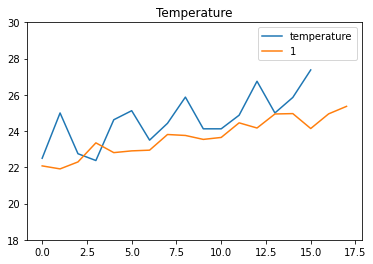

In [99]:
temperature_df.plot(title='Temperature', ylim=(18,30))

In [91]:
humidity_df = pd.concat([real_data[['humidity']], forecasted_data[[2]]], axis=1)

<AxesSubplot:title={'center':'Humidity'}>

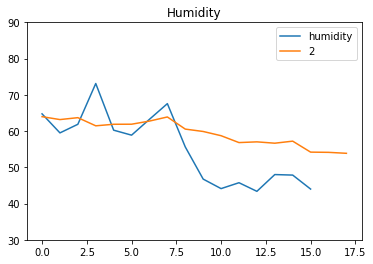

In [103]:
humidity_df.plot(title='Humidity', ylim=(30,90))

We're not exactly ready to start our own weather channel, but there is definitely evidence of learning.

---

## Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](dashboard.html) documentation.